In [ ]:
# Installing 'datasets' library for loading the IMDb dataset
!pip install datasets

In [ ]:
!pip install transformers datasets scikit-learn --quiet
# Importing necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm
import random


In [ ]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Use GPU if available, else fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load IMDb dataset using Hugging Face datasets library
dataset = load_dataset("imdb")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization to the entire dataset
def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

dataset = dataset.map(tokenize_fn, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Function to compute Signal-to-Noise Ratio (SNR) for model confidence analysis
def compute_snr(logits, labels):
    probs = torch.nn.functional.softmax(logits, dim=1)
    signal = probs[range(len(labels)), labels].detach().cpu().numpy()
    noise = np.sum(probs.detach().cpu().numpy(), axis=1) - signal
    snr = np.mean(signal / (noise + 1e-8))
    return snr

#  Function to train and evaluate the model on a given train/test split
def train_and_evaluate(train_idx, test_idx, run_name):
    train_subset = Subset(dataset["train"], train_idx)
    test_subset = Subset(dataset["train"], test_idx)

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=16)

# Load BERT model for binary classification
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
    optimizer = AdamW(model.parameters(), lr=5e-5)  # AdamW optimizer
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader))

    # Training
    model.train()
    for epoch in range(2):
        loop = tqdm(train_loader, desc=f"{run_name} - Epoch {epoch+1}")
        for batch in loop:
            batch = {k: v.to(device) for k, v in batch.items()}
            if 'label' in batch:
             batch['labels'] = batch.pop('label')  # Rename 'label' to 'labels' for the model
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward() #Backpropogation
            optimizer.step() #Updating weights
            lr_scheduler.step() # Updating learning rate
            optimizer.zero_grad() # Clear's gradients
            loop.set_postfix(loss=loss.item()) # Show current loss in progress bar

    # Evaluation
    model.eval()
    preds, true_labels, all_logits = [], [], []
    with torch.no_grad():
        for batch in test_loader:
          if 'label' in batch:
             batch['labels'] = batch.pop('label')
             batch = {k: v.to(device) for k, v in batch.items()}
             outputs = model(**batch)
          logits = outputs.logits
          preds.extend(torch.argmax(logits, axis=1).cpu().numpy()) # Predicted classes
          true_labels.extend(batch["labels"].cpu().numpy()) # Ground truth labels
          all_logits.append(logits)

    # Concatenate all logits for SNR computation
    all_logits = torch.cat(all_logits, dim=0)
    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    snr = compute_snr(all_logits, torch.tensor(true_labels))

    print(f"{run_name} - Accuracy: {acc:.4f}, F1: {f1:.4f}, SNR: {snr:.4f}")
    return acc, f1, snr

# Function to run 3x2 Balanced Cross-Validation
def run_bcv():
    total_size = len(dataset["train"])
    fold_size = total_size // 2 # Size of each fold
    indices = list(range(total_size))
    metrics = []

    for repeat in range(3):
        random.shuffle(indices)
        A = indices[:fold_size]
        B = indices[fold_size:2 * fold_size]

        print(f"\n=== Repetition {repeat + 1} ===")

# Train on A, test on B and vice versa
        acc1, f1_1, snr1 = train_and_evaluate(A, B, f"Run {repeat + 1}.1")
        acc2, f1_2, snr2 = train_and_evaluate(B, A, f"Run {repeat + 1}.2")

        metrics.append((acc1, f1_1, snr1))
        metrics.append((acc2, f1_2, snr2))

    # Average results
    avg = np.mean(metrics, axis=0)
    print(f"\n=== Final BCV Averages ===")
    print(f"Accuracy: {avg[0]:.4f}, F1: {avg[1]:.4f}, SNR: {avg[2]:.4f}")

# Run the full BCV evaluation
run_bcv()


=== Repetition 1 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Run 1.1 - Epoch 2: 100%|██████████| 782/782 [09:14<00:00,  1.41it/s, loss=0.0562]


Run 1.1 - Accuracy: 0.9104, F1: 0.9102, SNR: 78.7348


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Run 1.2 - Epoch 2: 100%|██████████| 782/782 [09:14<00:00,  1.41it/s, loss=0.046]


Run 1.2 - Accuracy: 0.9145, F1: 0.9151, SNR: 60.3805

=== Repetition 2 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Run 2.1 - Epoch 2: 100%|██████████| 782/782 [09:14<00:00,  1.41it/s, loss=0.369]


Run 2.1 - Accuracy: 0.9108, F1: 0.9121, SNR: 72.7713


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Run 2.2 - Epoch 2: 100%|██████████| 782/782 [09:14<00:00,  1.41it/s, loss=0.0831]


Run 2.2 - Accuracy: 0.9121, F1: 0.9133, SNR: 55.8280

=== Repetition 3 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Run 3.1 - Epoch 2: 100%|██████████| 782/782 [09:14<00:00,  1.41it/s, loss=0.178]


Run 3.1 - Accuracy: 0.9130, F1: 0.9133, SNR: 66.7584


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Run 3.2 - Epoch 2: 100%|██████████| 782/782 [09:14<00:00,  1.41it/s, loss=0.0576]


Run 3.2 - Accuracy: 0.9075, F1: 0.9086, SNR: 65.3012

=== Final BCV Averages ===
Accuracy: 0.9114, F1: 0.9121, SNR: 66.6291


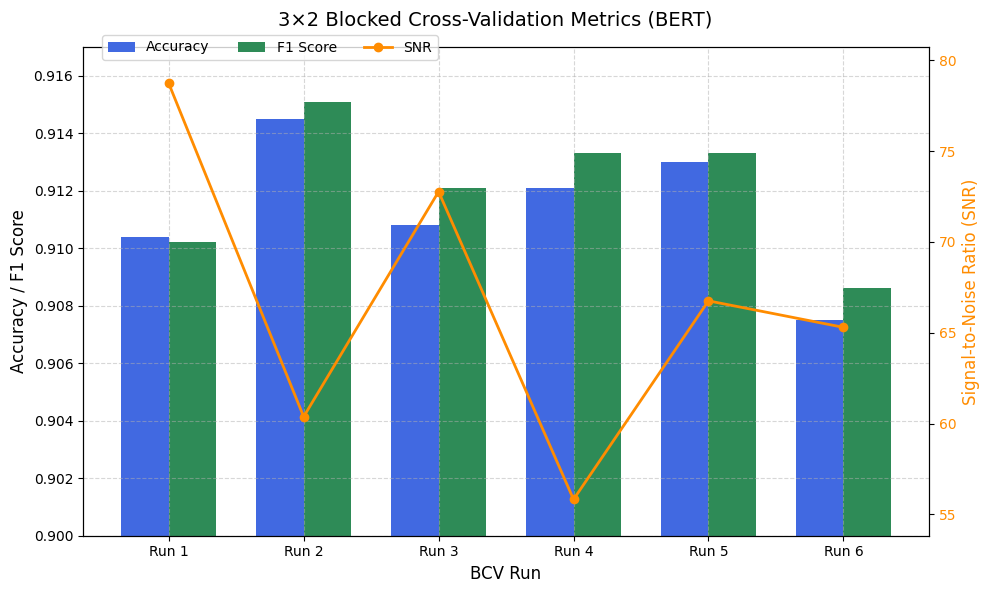

In [8]:
import matplotlib.pyplot as plt
import numpy as np


# Values from your log
accuracy_vals = [0.9104, 0.9145, 0.9108, 0.9121, 0.9130, 0.9075]
f1_vals       = [0.9102, 0.9151, 0.9121, 0.9133, 0.9133, 0.9086]
snr_vals      = [78.7348, 60.3805, 72.7713, 55.8280, 66.7584, 65.3012]

x = np.arange(len(accuracy_vals))  # x = [0, 1, 2, 3, 4, 5]
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy and F1 Score bars (left axis)
bar1 = ax1.bar(x - width/2, accuracy_vals, width, label='Accuracy', color='royalblue')
bar2 = ax1.bar(x + width/2, f1_vals, width, label='F1 Score', color='seagreen')

ax1.set_xlabel('BCV Run', fontsize=12)
ax1.set_ylabel('Accuracy / F1 Score', fontsize=12, color='black')
ax1.set_ylim(0.9, 0.917)
ax1.set_xticks(x)
ax1.set_xticklabels([f'Run {i+1}' for i in x])
ax1.tick_params(axis='y', labelcolor='black')

# SNR line (right axis)
ax2 = ax1.twinx()
line = ax2.plot(x, snr_vals, label='SNR', color='darkorange', marker='o', linewidth=2)
ax2.set_ylabel('Signal-to-Noise Ratio (SNR)', fontsize=12, color='darkorange')
ax2.set_ylim(min(snr_vals) - 2, max(snr_vals) + 2)
ax2.tick_params(axis='y', labelcolor='darkorange')

# Title and legends
fig.suptitle('3×2 Blocked Cross-Validation Metrics (BERT)', fontsize=14)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95), ncol=3)
ax1.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

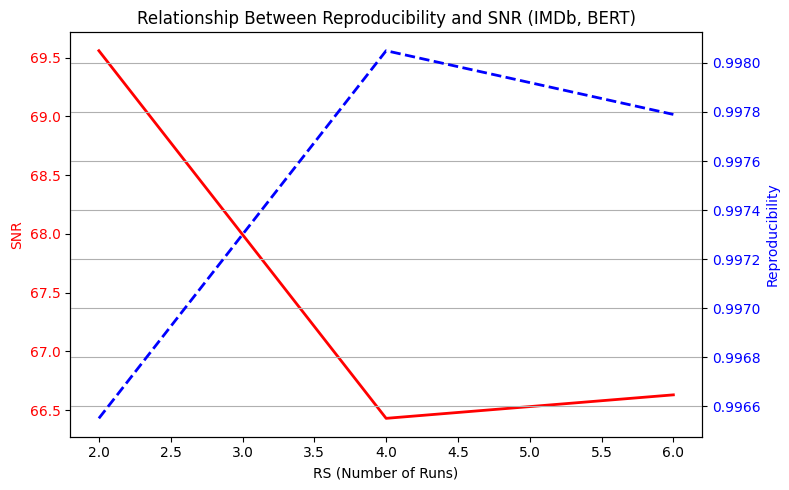

In [9]:


# RS values (Repetition Sizes)
rs = [2, 4, 6]

# Mean SNR at each RS
snr = [69.56, 66.43, 66.63]

# Reproducibility estimated as (1 - std deviation of F1 scores)
std_f1 = [0.00345, 0.00195, 0.00221]
reproducibility = [1 - s for s in std_f1]

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot SNR on left y-axis
ax1.set_xlabel("RS (Number of Runs)")
ax1.set_ylabel("SNR", color='red')
ax1.plot(rs, snr, 'r-', label='SNR', linewidth=2)
ax1.tick_params(axis='y', labelcolor='red')

# Plot reproducibility on right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Reproducibility", color='blue')
ax2.plot(rs, reproducibility, 'b--', label='Reproducibility', linewidth=2)
ax2.tick_params(axis='y', labelcolor='blue')

# Titles and legend
plt.title("Relationship Between Reproducibility and SNR (IMDb, BERT)")
fig.tight_layout()
plt.grid(True)
plt.show()